# Train a Bird Classification Model
Follow steps below to get started with a jupyter notebook for how to train a Towhee operator. This example fine-tunes a pretrained ResNet model (eg. resnet-34 pretrained by ImageNet) with a bird dataset.

# 1. Setup Operator
Create operator and load model by name.

In [1]:
import warnings #
warnings.filterwarnings("ignore") #
import towhee
# Set num_classes=400 for ResNet34 model (400 classes of birds in total)
op = towhee.ops.image_embedding.timm(model_name='resnet34', num_classes=400).get_op()

# 2. Configure Trainer:
Modify training configurations on top of default values.

In [2]:
from towhee.trainer.training_config import TrainingConfig

training_config = TrainingConfig()
training_config.batch_size = 32
training_config.epoch_num = 2
training_config.output_dir = 'bird_output'

# 3. Prepare Dataset
Download [BIRDS 400](https://www.kaggle.com/datasets/antoniozarauzmoreno/birds400) from Kaggle Dataset. And then create the dataset with local path and transform.


In [3]:
import os
from torchvision import transforms
from torchvision.datasets import ImageFolder

bird_400_path = './your_dataset_path/bird_400'

# imagenet default mean and std
std = (0.229, 0.224, 0.229)
mean = (0.485, 0.456, 0.406)
transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std),
                                transforms.RandomHorizontalFlip(p=0.5)
                               ])
train_data = ImageFolder(os.path.join(bird_400_path, 'train'), transform=transform)
eval_data = ImageFolder(os.path.join(bird_400_path, 'val'), transform=transform)

# 4. Start Training
Now start training the operator with Bird-400 dataset.

In [4]:
op.train(training_config, train_dataset=train_data, eval_dataset=eval_data)

2023-02-14 17:11:44,799 - 140428601104192 - trainer.py-trainer:319 - WARNING: TrainingConfig(output_dir='bird_output', overwrite_output_dir=True, eval_strategy='epoch', eval_steps=None, batch_size=32, val_batch_size=-1, seed=42, epoch_num=2, dataloader_pin_memory=True, dataloader_drop_last=True, dataloader_num_workers=0, lr=5e-05, metric='Accuracy', print_steps=None, load_best_model_at_end=False, early_stopping={'monitor': 'eval_epoch_metric', 'patience': 4, 'mode': 'max'}, model_checkpoint={'every_n_epoch': 1}, tensorboard={'log_dir': None, 'comment': ''}, loss='CrossEntropyLoss', optimizer='Adam', lr_scheduler_type='linear', warmup_ratio=0.0, warmup_steps=0, device_str=None, sync_bn=False, freeze_bn=False)


  0%|          | 0/1824 [00:00<?, ?step/s]

  0%|          | 0/1824 [00:00<?, ?step/s]

# 5. Predict
With the fine-tuned model, you can then use the operator to classify a bird picture.

2023-02-14 17:19:22,804 - 140428601104192 - image.py-image:721 - WARNING: Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


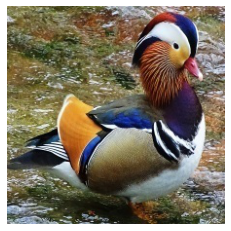

It is mandrin duck.
probability = 0.9768799543380737


In [5]:
from towhee.trainer.utils.plot_utils import predict_image_classification
import random
import matplotlib.pyplot as plt

random.seed(42)
img_index = random.randint(0, len(eval_data))
img = eval_data[img_index][0]
img_np = img.numpy().transpose(1, 2, 0)  # (C, H, W) -> (H, W, C)
img_np = img_np * std + mean
plt.axis('off')
plt.imshow(img_np)
plt.show()
img_tensor = eval_data[img_index][0].unsqueeze(0).to(op.trainer.configs.device)

prediction_score, pred_label_idx = predict_image_classification(op._model, img_tensor)
print('It is {}.'.format(eval_data.classes[pred_label_idx].lower()))
print('probability = {}'.format(prediction_score))

# 6.Interpret model
If you try to understand why this image will be classified as a mandrin duck, you can use `interpret_image_classification` utils in towhee, which using [captum](https://captum.ai/) as backend. So you must install it first using `pip install captum` or `conda install captum -c pytorch`.


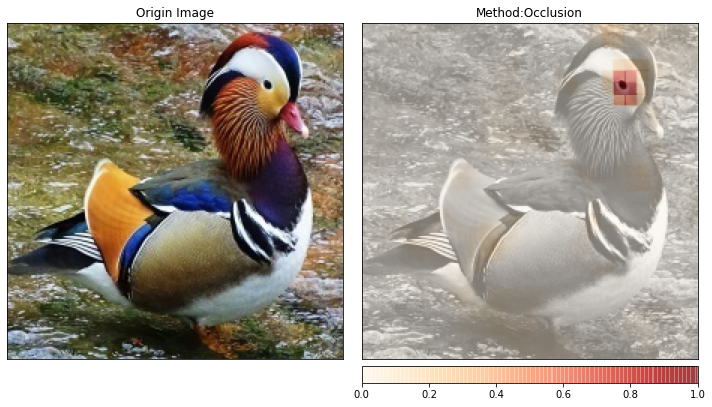

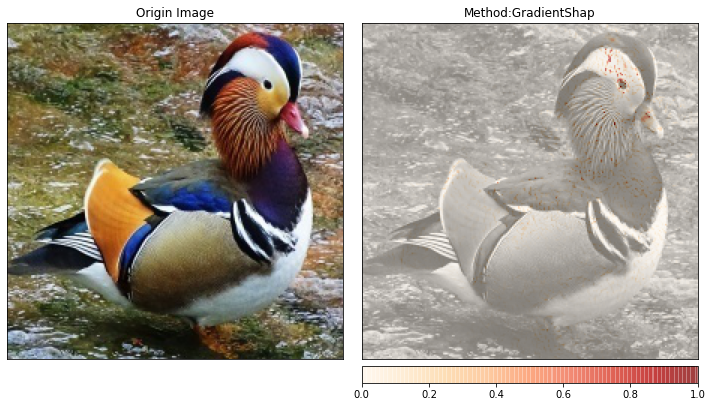

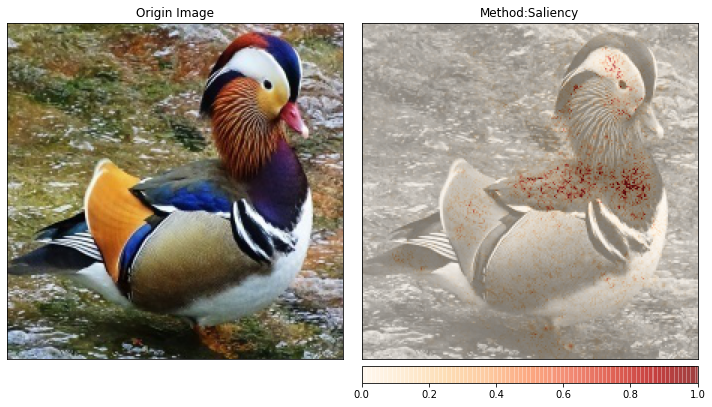

(0.9737352132797241, 261)

In [6]:
from PIL import Image
import numpy as np
from towhee.trainer.utils.plot_utils import interpret_image_classification
pil_img = Image.fromarray(np.uint8(img_np * 255))
val_transform = transforms.Compose([transforms.ToTensor(),
                                transforms.Normalize(mean=mean, std=std),
                               ])
interpret_image_classification(op._model.to('cpu'), pil_img, val_transform, "Occlusion")
interpret_image_classification(op._model.to('cpu'), pil_img, val_transform, "GradientShap")
interpret_image_classification(op._model.to('cpu'), pil_img, val_transform, "Saliency")